In [1]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import math
from scipy.spatial import cKDTree
from PASTE import *

  0%|          | 0/1 [00:00<?, ?it/s]

cuda:0


/home/lih0m/anaconda3/envs/stalign/lib/python3.7/site-packages/ot/lp/__init__.py:346: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


finish


100%|██████████| 1/1 [00:47<00:00, 47.29s/it]


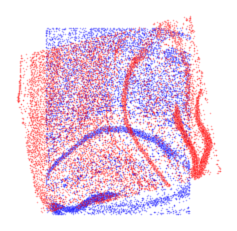

In [7]:
### STARmap PLUS (rotate 45 degree)


train_ad1 = sc.read_h5ad('./Dataset/8month_cr1_example_align.h5ad')
train_ad2 = sc.read_h5ad('./Dataset/8month_cr2_example_align.h5ad')

src_cor = np.array(train_ad1.obsm['spatial'])
tgt_cor = np.array(train_ad2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[ np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)

train_ad2.obsm['spatial'] = tgt_cor
train_ad1.obsm['spatial'] = src_cor

sc.pp.normalize_total(train_ad1)
sc.pp.normalize_total(train_ad2)

align_adatas,R,T = slice_alignment(
        [train_ad1,train_ad2],
        spatial_key = "spatial",
        key_added = "align_spatial",
        alpha = 0.1,
        numItermax = 500,
        numItermaxEmd= 100000,
        device = "cuda:0",
        std = 0)

plt.figure(figsize=(4,4))
plt.scatter(align_adatas[0].obsm['align_spatial'][:,0],align_adatas[0].obsm['align_spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.scatter(align_adatas[1].obsm['align_spatial'][:,0],align_adatas[1].obsm['align_spatial'][:,1],c='r',label='align_source',alpha=0.2,s=0.8)
plt.axis('off')
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

cuda:0


100%|██████████| 1/1 [00:25<00:00, 25.06s/it]

finish


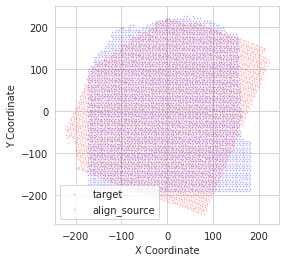

In [12]:
### DLPFC stitching (rotate 45 degree, 80% overlap)



train_ad1 = sc.read_h5ad('./Dataset/151507_preprocessed.h5')
train_ad2 = sc.read_h5ad('./Dataset/151508_preprocessed.h5')
train_ad1.X = np.array(train_ad1.X.todense())
train_ad2.X = np.array(train_ad2.X.todense())

adata1 = simulate_stitching(train_ad1, axis=0, from_low=True, threshold=0.1)
adata2 = simulate_stitching(train_ad2, axis=0, from_low=False, threshold=0.1)
train_ad1_part_overlap_index = adata1.obsm['spatial'][:,0] < np.max(adata2.obsm['spatial'][:,0])
train_ad2_part_overlap_index = adata2.obsm['spatial'][:,0] > np.min(adata1.obsm['spatial'][:,0])

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)
adata1.obsm['spatial'] = src_cor
adata2.obsm['spatial'] = tgt_cor


align_adatas,R,T = slice_alignment(
        [adata1,adata2],
        spatial_key = "spatial",
        key_added = "align_spatial",
        alpha = 0.1,
        numItermax = 500,
        numItermaxEmd= 100000,
        device = "cuda:0",
        std = 0)

plt.figure(figsize=(4,4))
plt.scatter(align_adatas[0].obsm['align_spatial'][:,0],align_adatas[0].obsm['align_spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.scatter(align_adatas[1].obsm['align_spatial'][:,0],align_adatas[1].obsm['align_spatial'][:,1],c='r',label='align_source',alpha=0.2,s=0.8)
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

cuda:1
finish


  9%|▉         | 1/11 [00:19<03:13, 19.35s/it]

cuda:1
finish


 18%|█▊        | 2/11 [00:38<02:55, 19.47s/it]

cuda:1
finish


 27%|██▋       | 3/11 [00:58<02:37, 19.68s/it]

cuda:1
finish


 36%|███▋      | 4/11 [01:16<02:13, 19.00s/it]

cuda:1
finish


 45%|████▌     | 5/11 [01:32<01:47, 17.95s/it]

cuda:1
finish


 55%|█████▍    | 6/11 [01:48<01:25, 17.12s/it]

cuda:1
finish


 64%|██████▎   | 7/11 [02:03<01:05, 16.48s/it]

cuda:1
finish


 73%|███████▎  | 8/11 [02:19<00:49, 16.34s/it]

cuda:1
finish


 82%|████████▏ | 9/11 [02:35<00:32, 16.05s/it]

cuda:1
finish


 91%|█████████ | 10/11 [02:49<00:15, 15.46s/it]

cuda:1
finish


100%|██████████| 11/11 [03:03<00:00, 16.64s/it]


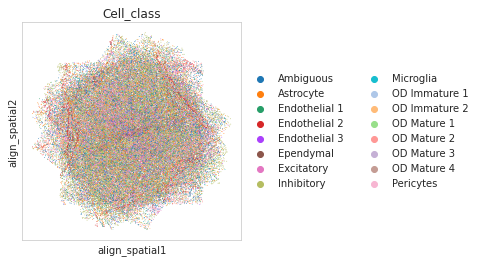

In [11]:
### MERFISH datset

adata = sc.read_h5ad('./Dataset/MERFISH.h5ad')
slice_ids = np.unique(adata.obs.Bregma)
#slice_ids[::-1].sort()
adatas = [adata[adata.obs.Bregma == i,:].copy() for i in slice_ids]

align_adatas,R,T = slice_alignment(
    adatas,
    spatial_key = "spatial",
    key_added = "align_spatial",
    alpha = 0.2,
    numItermax = 100,
    numItermaxEmd= 100000,
    device = "cuda:1",
    std = 0)
final_adata = ad.concat(align_adatas,axis=0,join='inner')
sc.pl.spatial(final_adata,color='Cell_class',basis='align_spatial',spot_size=10)